#### Содержание

##### Сбор данных

- Сбор данных

##### Преобразование, проверка и описание данных

- Выбираем данные для анализа
- Проверяем данные
- Добавляем метрики
- Описываем дф

##### Аналитика метрик

- Аналитика хештегов
- Аналитика прикрепленного контента
- Аналитика дней недели
- Аналитика времени публикации

##### Рекомендации

- Рекомендации

### Сбор данных

#### Сбор данных
Импортируем библиотеки, формируем запросы, сохраняем ответы

In [88]:
# Импорт необходимых библиотек
import requests
from datetime import datetime, timedelta
import pandas as pd
import re
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import json

In [89]:
# Данные для запроса: токен, версия, домен группы

service_token = '165d61ca165d61ca165d61ca6916289ba51165d165d61ca76584ebeba9d3ff8801e1224'
version = '5.92'
domain_public = 'skillbox_education'

In [90]:
# Функция для получения данных по запросу

def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

In [118]:
# Номер поста. Нумерация от самого нового
offset = 0

# Количество постов в 1м запросе
count = 1

# Список ответов сервера
responses = []

# Цикл работает следующим образом: Считываем 1 пост; добавляем информацию о посте в лист responses; присваиваем переменной days
# значение: сегодняшняя дата - дата поста, и пока days меньше 365 - цикл продолжается; добавляем к offset 1, чтобы 
# в новой итерации цикла перейти к следующему посту

days = 0
while days  < 365:
    
    url = 'https://api.vk.com/method/wall.get?access_token='+ \
    service_token + '&offset='+ str(offset) + '&count=' + str(count) + '&v=' + version + '&domain=' + domain_public
    response = getjson(url)
    responses.append(response)
    
    days = (datetime.now() - datetime.fromtimestamp(response['response']['items'][0]['date'])).days
    offset += 1

### Преобразование, проверка и описание данных


#### Выбираем данные для анализа
Формируем списки данных, из списков формируем датафрейм

In [126]:
# Создадим списки данных, которые мы будем анализировать и заполним эти списски с помощью цикла

# Списки данных для анализа
post_id = []
views = []
likes = []
comments = []
reposts = []

date = []
hash_tags = []

attachments = []

# регулярное выражение для поиска хештегов
expr = r'#\w+'

# Цикл работает следующим образом: каждая итерация - это обработка 1го поста. Мы извлекаем из поста необходимую информацию и 
# сохраняем ее в списки данных для анализа

for j in range(len(responses)):
    for i in range(count):
        
        # Общую часть запроса к json словарю определим переменной
        main_dict = responses[j]['response']['items'][i]
        
        # Список id постов
        post_id.append(main_dict['id'])
        
        # Список количества просмотров постов
        views.append(main_dict['views']['count'])
        
        # Список количества лайков
        likes.append(main_dict['likes']['count'])
        
        # Список количества комментариев
        comments.append(main_dict['comments']['count'])
        
        # Список количества репостов
        reposts.append(main_dict['reposts']['count'])
        
        
        # Список преобразованных дат
        date.append((datetime.fromtimestamp(main_dict['date']) - timedelta(hours=0)))
        
        # Находим хэштеги
        tags = re.findall(expr, main_dict['text'])
        
        # Список преобразованных хэштегов
        hash_tags.append(list(map(lambda x: x[1:].lower().replace('_', ' ').replace('skillbox', '').strip(),tags)))
        
           
        # Список типов прикреплений
        attachment = list()
        
        try:   
            for i_attach in range(len(main_dict['attachments'])):
                attachment.append(main_dict['attachments'][i_attach]['type'])
        except:   
            attachment.append(None)
            
        attachments.append(attachment)

In [127]:
# Создадим пустой дф и наполним его полученными списками

# Создаем пустой дф
data = pd.DataFrame()

# Наполняем датафрейм полученными списками
data['id'] = post_id
data['views'] = views
data['likes'] = likes
data['comments'] = comments
data['reposts'] = reposts

data['date'] = date
data['tags'] = hash_tags

data['attachments'] = attachments

data.head(2)

,id,views,likes,comments,reposts,date,tags,attachments
0,251053,100352,874,129,246,2022-07-12 17:39:28,[жизньпосле],[video]
1,259670,8410,15,6,1,2022-09-07 13:20:30,[],"[photo, poll]"


#### Проверяем данные
Проверяем данные на наличие пропущенных значений, дубликатов

In [128]:
# Проверяем данные на наличие пропущенных значений

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           514 non-null    int64         
 1   views        514 non-null    int64         
 2   likes        514 non-null    int64         
 3   comments     514 non-null    int64         
 4   reposts      514 non-null    int64         
 5   date         514 non-null    datetime64[ns]
 6   tags         514 non-null    object        
 7   attachments  514 non-null    object        
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 32.2+ KB


In [129]:
# Чтобы проверить данные на наличие дубликатов, нужно изменить тип данных в столбцах tags и attachments c list на str

# Добавим функцию, которая из списка слов, возвращает уникальные слова
def unique_list(l):
    
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    
    return ulist


# преобразуем типы

data.attachments = data.attachments.apply(unique_list).str.join(' ')
data.tags = data.tags.str.join('')

data.head(2)

,id,views,likes,comments,reposts,date,tags,attachments
0,251053,100352,874,129,246,2022-07-12 17:39:28,жизньпосле,video
1,259670,8410,15,6,1,2022-09-07 13:20:30,,photo poll


In [130]:
# Проверяем количество дубликатов

data.duplicated().sum()

0

##### Итог
- Пропущенных значений не обнаруженно
- Дублирующих строк не обнаруженно

#### Добавляем метрики 
Добавим день публикации, является ли этот день выходным, час публикации, и метрику вовлеченности.   

##### ВременнЫе метрики

In [131]:
# День публикации
data['day_of_week'] = data.date.dt.dayofweek

# Добавим столбец название дня, для более приятного визуала графиков
data['day_name'] = data.date.dt.day_name()

# Является ли этот день выходным
data['its_weekend'] = data['day_of_week'].isin([5, 6])

# Час публикации
data['hour'] = data.date.dt.hour


data.head(2)

,id,views,likes,comments,reposts,date,tags,attachments,day_of_week,day_name,its_weekend,hour
0,251053,100352,874,129,246,2022-07-12 17:39:28,жизньпосле,video,1,Tuesday,False,17
1,259670,8410,15,6,1,2022-09-07 13:20:30,,photo poll,2,Wednesday,False,13


##### Метрика вовлеченности
В качестве метрики вовлеченности мы будем использовать сумму активностей пользователя (лайки, комментарии, репосты) деленную на количество просмотров и умноженную на 1000. Таким образом мы получим коефициент активности пользователя на 1000 показов. 

Однако, лайки, комментарии и репосты для нас это неравнозначные величины. Лайк очень простое действие и потому самое массовое. Комментарий - более трудоемкое действие и сопровождается большим количеством эмоций чем лайк, а репост это самое удачное для нас действие которое может сделать пользователь. 

Чтобы привести активности к равнозначности, посмотрим сколько приходится лайков на один комментарий и домножим все комментарии на это количество. Таким образом мы получим "цену" комментария в лайках. То же самое мы сделаем для репостов

In [132]:
# Медианное количество лайков, комментариев и репостов для каждого поста
activity_medians = data[['likes', 'comments', 'reposts']].median()

# Теперь найдем коэффициенты
c_comments = activity_medians.likes / activity_medians.comments
c_reposts = activity_medians.likes / activity_medians.reposts

# Домножим коэффициенты на активности, чтобы получить "взвешенную" активность
data['comments_suspended'] = data.comments * c_comments
data['reposts_suspended'] = data.reposts * c_reposts

# И теперь найдем коэффициент вовлеченности. Назовем его 'er'. Возьмем взвешенную сумму активностей разделим на количество 
# просмотров и домножим на 1000.
data['er'] = data[['likes', 'comments_suspended', 'reposts_suspended']].sum(axis=1).div(data.views, axis=0) * 1000

data.head(2)

,id,views,likes,comments,reposts,date,tags,attachments,day_of_week,day_name,its_weekend,hour,comments_suspended,reposts_suspended,er
0,251053,100352,874,129,246,2022-07-12 17:39:28,жизньпосле,video,1,Tuesday,False,17,2064.0,463.058824,33.891291
1,259670,8410,15,6,1,2022-09-07 13:20:30,,photo poll,2,Wednesday,False,13,96.0,1.882353,13.422396


#### Описываем дф
Количество постов, количество хештегов, среднее количество постов в день, медианное количество активостей для одного поста

In [133]:
# Количество постов
data.shape[0]

514

In [134]:
# количество хештегов
data.tags.nunique()

29

In [135]:
# среднее количество постов в день
data.shape[0]/365

1.4082191780821918

In [136]:
# медианное количество лайков, комментариев, репостов для одного поста
data[['likes', 'comments', 'reposts']].median()

likes       32.0
comments     2.0
reposts     17.0
dtype: float64

Общее количество постов - 514. Количество уникальных хештегов 29. Среднее количество постов в день - 1.4. Медианное количество лайков, комментариев, репостов - 32, 2, 17.

### Аналитика хештегов

#### Аналитика медианного количества просмотров в зависимости от хэштега

In [150]:
# Сформируем дф с интересующими нас метриками и сгруппируем его

data_hash = data[['views', 'er',  'tags']].groupby('tags', as_index=False).median()

Text(0, 0.5, 'Хештеги')

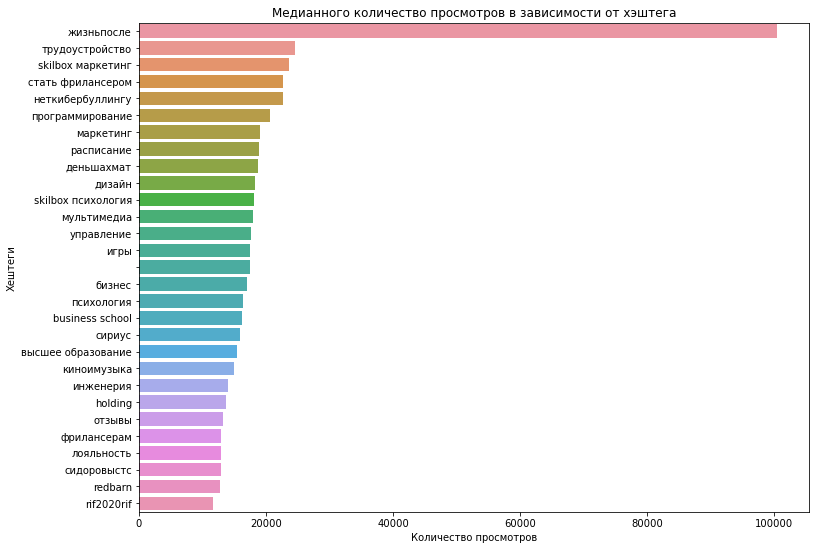

In [151]:
# Инициализируем график, задаем размер
fig, ax = plt.subplots(figsize=(12, 9))

# создаем переменную с информацией для построения графика
data_for_graf = data_hash.sort_values('views', ascending=False)

# наносим на график информацию из переменной
sns.barplot(data=data_for_graf, x='views', y='tags')

# Устанавливаем название графика и подписываем оси координат
ax.set_title('Медианного количество просмотров в зависимости от хэштега')
ax.set_xlabel('Количество просмотров')
ax.set_ylabel('Хештеги')

#### Вывод

Самые просматриваемые хэштэги - это "жизньпосле" и "трудоустройство". Самые не просматриваемые - "rif2020rif" и "redbarn". Хештег "жизньпосле" очень просматриваемый. Его медианное значение просмотров в несколько раз больше 2го по популярности хештега. Все остальные хештеги достаточно близки друг к другу.

#### Аналитика медианной вовлеченности в зависимости от хэштега

<AxesSubplot:xlabel='er', ylabel='tags'>

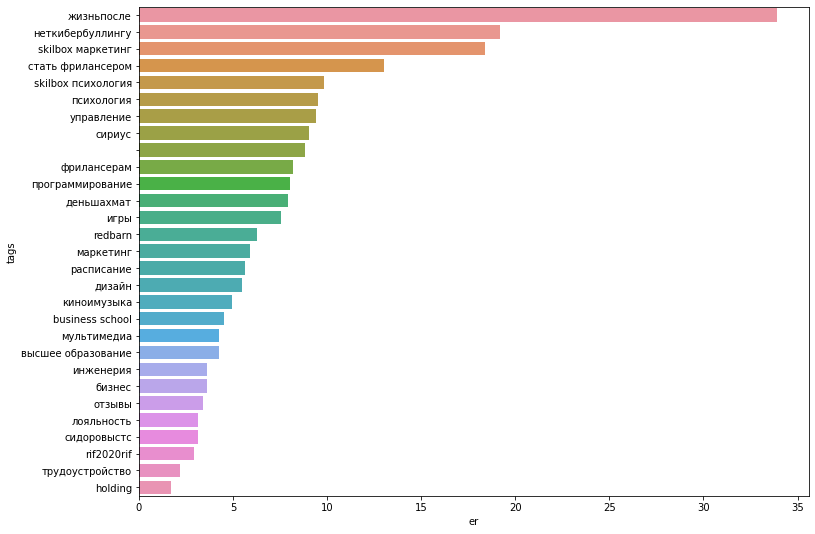

In [152]:
fig, ax = plt.subplots(figsize=(12, 9))

data_hash = data[['views', 'er',  'tags']].groupby('tags', as_index=False).median()

data_for_graf = data_hash.sort_values('er', ascending=False)
    
sns.barplot(data=data_for_graf, x='er', y='tags')

#### Вывод

Хэштэги с самой высокой вовлеченностью - это "жизньпосле" и "нет кибербулингу". С самой низкой вовлеченностью - "holding" и "трудоустройство". Хештег "жизньпосле" самый побуждающий к действию. 
График вовлеченности в отличие от графика просмотров, имеет более высокое среднее отклонение.

### Аналитика прикрепленного контента 

In [148]:
data_attach = data[['views', 'likes', 'comments', 'reposts', 'attachments']].groupby('attachments').median()

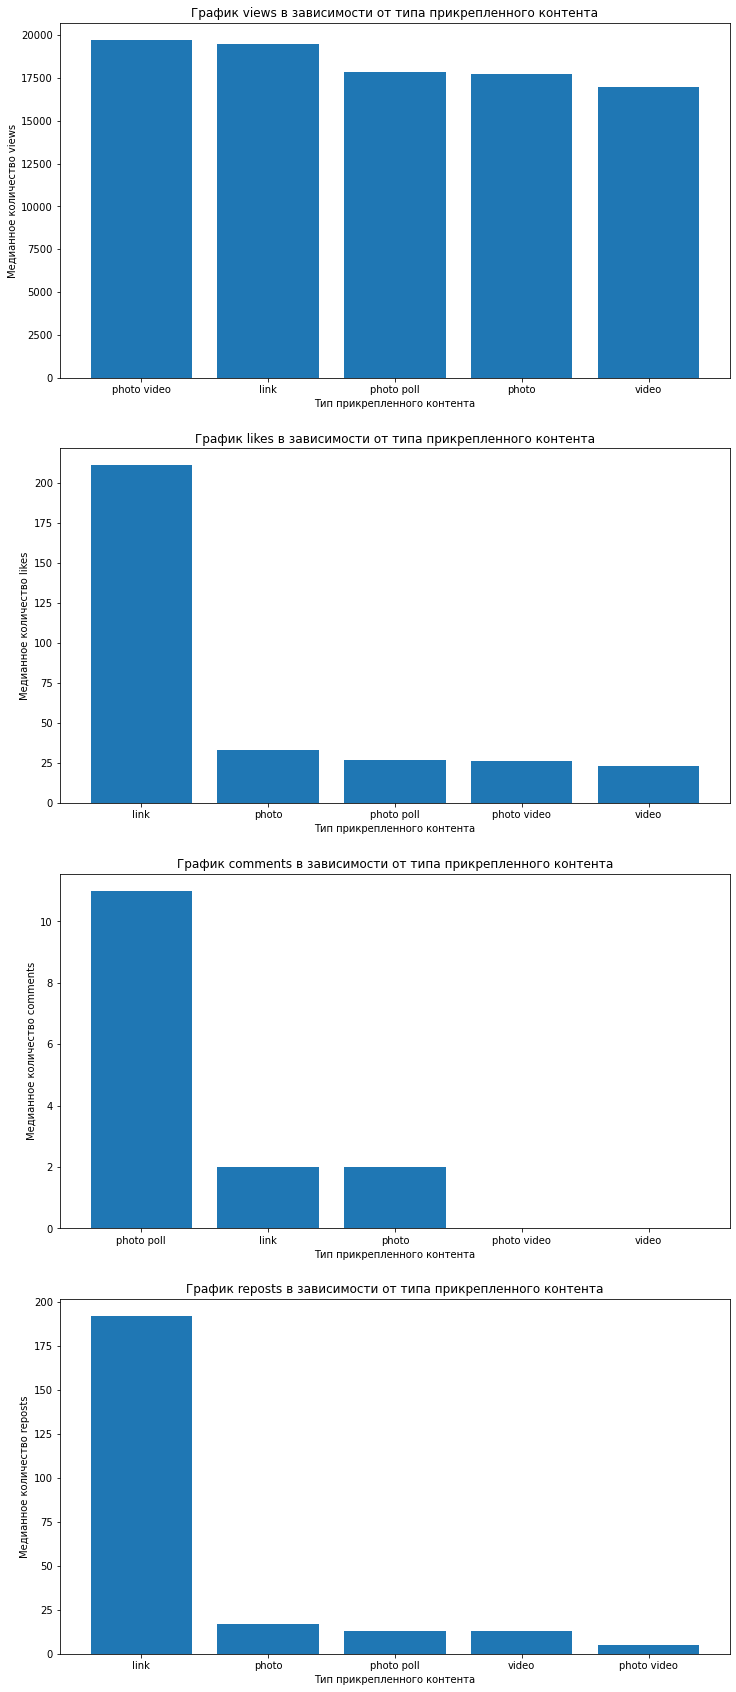

In [149]:
fig, axs = plt.subplots(nrows=data_attach.shape[1], figsize=(12, 30))

for i, metric in enumerate(data_attach.columns):
    
    data_for_graph = data_attach[metric].sort_values(ascending=False)

    axs[i].bar(data_for_graph.index, data_for_graph.values)

    axs[i].set_title(f'График {metric} в зависимости от типа прикрепленного контента')
    axs[i].set_xlabel('Тип прикрепленного контента')
    axs[i].set_ylabel(f'Медианное количество {metric}')

#### Вывод

График показывает, что пользователи хорошо реагируют на ссылки. Ссылки имеют большой отрыв по медианному количеству лайков и репостов. Голосование имеет большой отрыв в медианном количестве комментариев. Похоже что пользователи хотят обсудить варианты ответов голосования и высказать свою точку зрения

### Аналитика дней недели

In [141]:
data_days = data[['views', 'er', 'day_of_week', 'day_name']] \
    .groupby(['day_name']) \
    .median() \
    .sort_values('day_of_week') \
    .copy()

data_days = data_days[['views', 'er']]
data_days.head(2)

,views,er
day_name,,
Monday,18007.0,6.060771
Tuesday,17490.0,6.878964


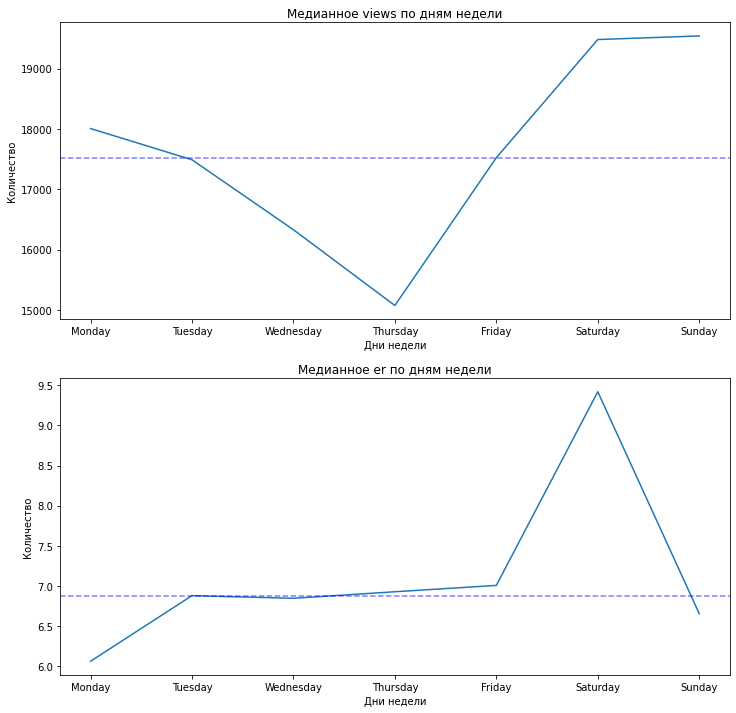

In [153]:
fig, axs = plt.subplots(nrows=data_days.shape[1], figsize=(12, 12))

for i, metric in enumerate(data_days.columns):

    data_for_graph = data_days[metric]

    axs[i].plot(data_for_graph)
    axs[i].axhline(data_days[metric].median(), label='median', color='b', linestyle='--', alpha=0.5)
    
    axs[i].set_title(f'Медианное {metric} по дням недели')
    axs[i].set_xlabel('Дни недели')
    axs[i].set_ylabel('Количество')

#### Вывод

На графике просмотров самые высокие значения у воскресенья и субботы. Самые низкие значения на графике просмотров у среды и четверга. Судя по графику можно предположить что ЦА тратит больше времени на соцсети по выходным 

На графике вовлеченности  самые высокие значения у субботы и пятницы. Самые низкие значения на графике просмотров у понедельника и воскресенья. 

В целом глядя на графики, можно сказать что активность в выходные дни - очень высокая относительно остальной недели.
Несмотря на то что в воскресенье наибольшее количество просмотров мы видим резкий спад количества комментариев и репостов с субботы на воскресенье. Возможно это связанно с контент-планом и субботними публикациями.

### Аналитика времени публикации

#### Анализ количества просмотров в зависимости от времени публикации для будних и выходных дней

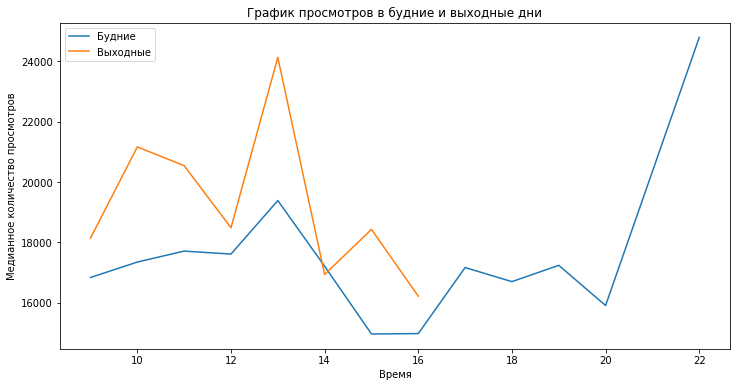

In [143]:
fig, ax = plt.subplots(figsize=(12, 6))

for i in [0, 1]:
    
    data_for_graf = data[data.its_weekend == i][['views', 'hour']] \
        .groupby('hour') \
        .median()
    
    ax.plot(data_for_graf, label=['Будние', 'Выходные'][i*1])
    
ax.set_title('График просмотров в будние и выходные дни')
ax.set_xlabel('Время')
ax.set_ylabel('Медианное количество просмотров')


plt.legend();

#### Вывод

Для будних дней самое популярное время с точке зрения просмотров - 22:00 и 21:00. По тренду с 20:00 до пиковой точки, можно сделать предположение, что крупный кусок целевой аудитории смотрит соцсети именно вечером. Возможно это вид отдыха после рабочего дня/обучения. Также возможно с 13:00 до 14:00 у большого количества людей из ЦА длительныцй перерыв и они тратят это время на соцсети, поэтому у постов которые запостили в это время - много просмотров. Самое непопулярное время в будние дни - это 15:00 и 16:00

Для выходных дней самое популярное время это 13:00 и 10:00. Самое непопулярное - 14:00 и 16:00. По графику мы видим что после 16:00 публикаций по выходным дням не бывает. Судя по тому что график выходных дней находится выше и почти не пересекает график будних дней - просмотров в выходные дни в среднем больше. Поэтому стоит попробовать опубликовать несколько постов после 16:00 и посмотреть на просмотры.

#### Анализ вовлеченности в зависимости от времени публикации для рабочих и выходных дней

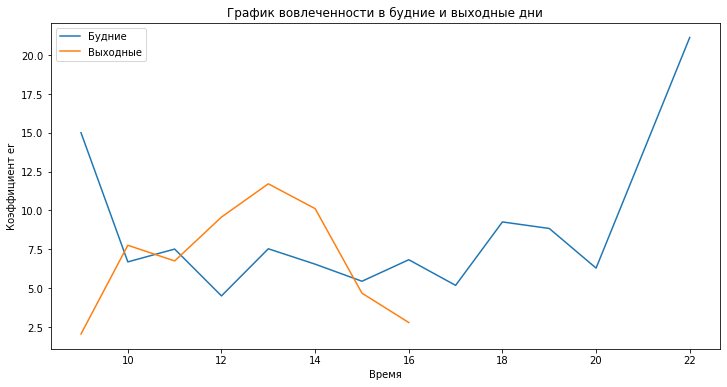

In [144]:
fig, ax = plt.subplots(figsize=(12, 6))

for i in [0, 1]:
    
    data_for_graf = data[data.its_weekend == i][['er', 'hour']] \
        .groupby('hour') \
        .median()
    
    ax.plot(data_for_graf, label=['Будние', 'Выходные'][i*1])
    
ax.set_title('График вовлеченности в будние и выходные дни')
ax.set_xlabel('Время')
ax.set_ylabel('Коэффициент er')


plt.legend();

#### Вывод

По будням самые высокие значения в 22:00 и 21:00. Самые низкие - 12:00, 17:00. На графике для будней мы видим сильный тренд вовлеченности после 20:00. Учитывая что в это время растет не только вовлеченность, но и просмотры - можно сделать вывод, что это хорошее время для постинга. 
На выходных самые высокие значения вовлеченности в 13:00 и 14:00. Самые низкие 9:00 и 16:00.
Сравнивая графики мы видим что утром выходного дня вовлеченность очень низкая в отличии от утра рабочего дня.

### Рекомендации

В ходе выполнения аналитики над собранными данными, одной из рекомендаций к сотрудникам SMM-отдела хотелось бы отнести более частое написание хештегов, для более качественного анализа паблика вдальнейшем.

Остро-социальные хештеги набирают большое количество просмотров и пользователи имеют большое желание взаимодействовать с такими постами. Глядя на графики хештегов можно сделать вывод что социальные проблемы для пользователей имеют гораздо больший эмоциональный отклик, чем "полезные" хештеги. Например хештег "трудоустройство" 2й по просмотрам, но предпоследний по активности.

Из всех типов прикрепленного контента у ссылок наибольший процент лайков и репостов, поэтому их можно использовать для постов рассчитанных на повышение охватов. В свою очередь, голосования - сильно побуждают пользователя написать комментарий

В выходные дни пользователи более активны. Наблюдается большой рост просмотров именно на выходных. Вовлеченность максимальная в субботу, но в воскресенье она сильно падает

Чтобы понять в какое время лучше выкладывать посты, стоит условно разделить посты на 3 смысловые категории: 

1 Посты рассчитанные на повышение лояльности: 
посты несущие пользу ЦА, но не интересные для широкой аудитории. Такие посты стоит выкладывать опираясь не на просмотры, а на вовлеченность. 
Будни 8:00 - 10:00 и 20:00 - 22:00

2 Посты рассчитанные на повышение охватов. Менее специализированные посты интересные большему кругу пользователей. Такие посты стоит выкладывать опираясь именно на просмотры.
Будни 12:00 - 14:00 и 20:00 - 22:00

3 Самые сильные посты, которые и повышают охваты и повышают лояльность. Посты интересные широкому кругу пользователей, при этом имеющие сильный эмоциональный отклик, побуждающий к активности. 
Выходные 12:00 - 14:00. 

В выходные дни нет постов, которые выкладывают после 17:00. Судя по графикам дневных просмотров и вовлеченности стоит протестировать 2 гипотезы:
1. Самые сильные посты стоит выкладывать в субботу в 20:00 - 22:00
2. Самые сильные посты стоит выкладывать в воскресенье в 20:00 - 22:00


